In [1]:
import torch
from torch.utils.data import ConcatDataset, StackDataset, DataLoader
torch.serialization.add_safe_globals([StackDataset, ConcatDataset])
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = torch.load("/w/150/lambda_squad/misc/rnnsuperposition/data/train_data/copy_transcoder/1M_128_update_gate.pt")

## Dataset Metrics

In [10]:
batch_size = len(dataset)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Statistics for 12923204 vectors:
Mean norm: 6.5813
Standard deviation: 1.7551
Min norm: 3.3356
Max norm: 9.1959
Median norm: 6.7645


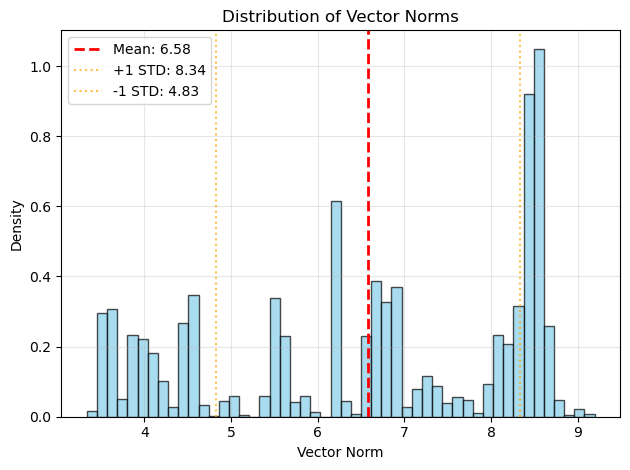

In [30]:
for batch in dataloader:
    outputs = batch["output"]
    norms_np = torch.norm(outputs, dim=-1).detach().cpu().numpy()
    # Plot histogram
    plt.hist(norms_np, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.xlabel('Vector Norm')
    plt.ylabel('Density')
    plt.title('Distribution of Vector Norms')
    plt.grid(True, alpha=0.3)

    # Add some statistics as text
    mean_norm = np.mean(norms_np)
    std_norm = np.std(norms_np)
    plt.axvline(mean_norm, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_norm:.2f}')
    plt.axvline(mean_norm + std_norm, color='orange', linestyle=':', alpha=0.7, label=f'+1 STD: {mean_norm + std_norm:.2f}')
    plt.axvline(mean_norm - std_norm, color='orange', linestyle=':', alpha=0.7, label=f'-1 STD: {mean_norm - std_norm:.2f}')

    plt.legend()

    # Print some statistics
    print(f"Statistics for {len(norms_np)} vectors:")
    print(f"Mean norm: {mean_norm:.4f}")
    print(f"Standard deviation: {std_norm:.4f}")
    print(f"Min norm: {np.min(norms_np):.4f}")
    print(f"Max norm: {np.max(norms_np):.4f}")
    print(f"Median norm: {np.median(norms_np):.4f}")

    plt.tight_layout()
    plt.show()    
    break  


## Prediction Metrics

In [3]:
import sys
import os
sys.path.insert(0, '/w/150/lambda_squad/misc/rnnsuperposition/models')
from transcoders import Transcoder
transcoder = Transcoder(159, 128, 1024)
transcoder.load_state_dict(torch.load("/w/150/lambda_squad/misc/rnnsuperposition/data/models/copy_transcoder/local_models/nornom_s_1_ls_05_nopen_of200_1024_nodet_270e/final_model.ckpt")["transcoder"])

<All keys matched successfully>

In [4]:
batch_size = 64
testing_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
with torch.no_grad():
    for batch in testing_dataloader:
        inputs = batch["input"]
        targets = batch["output"]
        replace_out, feats_act, pre_feats = transcoder(inputs)
        bias_out = ((targets - transcoder.features_to_outputs.bias) **2).mean()
        recon_error = torch.nn.MSELoss()(replace_out, targets)
        print(recon_error, bias_out)
        print(feats_act.mean(), replace_out.mean(), targets.mean(), transcoder.features_to_outputs.bias.mean())
        break

tensor(0.0716) tensor(0.0716)
tensor(0.) tensor(0.5193) tensor(0.4843) tensor(0.5193)


In [10]:
transcoder.features_to_outputs.bias

Parameter containing:
tensor([0.6635, 0.6478, 0.2968, 0.6646, 0.3024, 0.6195, 0.5972, 0.6230, 0.5944,
        0.6162, 0.2606, 0.2997, 0.3629, 0.6864, 0.2707, 0.2580, 0.7449, 0.2385,
        0.7041, 0.6346, 0.6703, 0.6717, 0.6478, 0.2789, 0.3135, 0.2667, 0.6578,
        0.2724, 0.6479, 0.6590, 0.2892, 0.6386, 0.6420, 0.6141, 0.7047, 0.2263,
        0.4238, 0.6437, 0.6394, 0.6341, 0.5455, 0.8090, 0.6707, 0.5816, 0.3437,
        0.6672, 0.8819, 0.6457, 0.2452, 0.6433, 0.6003, 0.6443, 0.4127, 0.5876,
        0.6126, 0.6063, 0.6350, 0.4654, 0.6418, 0.5797, 0.2627, 0.3523, 0.6279,
        0.3107, 0.6411, 0.6769, 0.6422, 0.6084, 0.3165, 0.2710, 0.7106, 0.5868,
        0.3579, 0.6861, 0.5321, 0.2510, 0.2169, 0.5392, 0.6823, 0.2945, 0.7721,
        0.2424, 0.4071, 0.6076, 0.6021, 0.5521, 0.2389, 0.5788, 0.6355, 0.2573,
        0.6577, 0.3157, 0.6110, 0.8100, 0.6568, 0.6465, 0.6222, 0.6446, 0.6654,
        0.2839, 0.6262, 0.6811, 0.3295, 0.3505, 0.2590, 0.5552, 0.6250, 0.4655,
        0.7140, 0.

In [13]:
torch.norm(dataset[0]["output"])

tensor(6.2289)

In [20]:
torch.norm(dataset[72000]["input"])

tensor(3.4381)